In [ ]:
#import necessary library
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

#drive's local file
sorbian_path = '/content/drive/MyDrive/Colab Notebooks/train.hsb-de.hsb'
german_path = '/content/drive/MyDrive/Colab Notebooks/train.hsb-de.de'

#read hsb sentences
with open(sorbian_path, 'r', encoding='utf-8') as f:
    sorbian_sentences = f.readlines()

#read german sentences
with open(german_path, 'r', encoding='utf-8') as f:
    german_sentences = f.readlines()



Mounted at /content/drive


In [ ]:
#count sentences
print(len(sorbian_sentences))
print(len(german_sentences))

60000
60000


In [ ]:
#count basic informtion of data set
import re
from collections import Counter
from statistics import mean
import pandas as pd

SORBIAN_PATH = '/content/drive/MyDrive/Colab Notebooks/train.hsb-de.hsb'
GERMAN_PATH  = '/content/drive/MyDrive/Colab Notebooks/train.hsb-de.de'

# Tokenizer
_PUNCT = r"""!"#$%&'()*+,\-./:;<=>?@[\]^_`{|}~„“”’…«»"""
PUNCT_RE = re.compile(rf"^[{re.escape(_PUNCT)}]+|[{re.escape(_PUNCT)}]+$")

def tokenize(line: str):
    toks = []
    for t in line.strip().split():
        t = PUNCT_RE.sub("", t)
        if t:
            toks.append(t)
    return toks

def file_stats(path: str, encoding="utf-8"):
    n_sent = 0
    sent_lens = []
    token_counter = Counter()

    with open(path, "r", encoding=encoding, errors="ignore") as fh:
        for line in fh:
            line = line.strip()
            if not line:
                continue
            n_sent += 1
            toks = tokenize(line)
            sent_lens.append(len(toks))
            token_counter.update(toks)

    n_tokens = sum(token_counter.values())
    n_types = len({t.lower() for t in token_counter.keys()})
    avg_len = mean(sent_lens) if sent_lens else 0.0
    min_len = min(sent_lens) if sent_lens else 0
    max_len = max(sent_lens) if sent_lens else 0
    return {
        "Sentences": n_sent,
        "Tokens": n_tokens,
        "Types": n_types,
        "Avg Len": round(avg_len, 1),
        "Min Len": min_len,
        "Max Len": max_len
    }

# 计算
de_stats  = file_stats(GERMAN_PATH)
hsb_stats = file_stats(SORBIAN_PATH)

# 转成DataFrame
df = pd.DataFrame([de_stats, hsb_stats], index=["German (de)", "Upper Sorbian (hsb)"])
print(df)


                     Sentences  Tokens  Types  Avg Len  Min Len  Max Len
German (de)              60000  724136  49989     12.1        1       80
Upper Sorbian (hsb)      60000  639312  65550     10.7        1       78


In [ ]:
#dataset preprocess
def clean_and_align(sorbian_sentences, german_sentences, max_len=128):


    # Step 1: 清理空白和换行 remove empty sentences and /n
    sorbian_sentences = [s.strip() for s in sorbian_sentences if s.strip()]
    german_sentences = [s.strip() for s in german_sentences if s.strip()]

    # Step 2: 保持长度一致 keep align
    min_len = min(len(sorbian_sentences), len(german_sentences))
    sorbian_sentences = sorbian_sentences[:min_len]
    german_sentences = german_sentences[:min_len]

    # Step 3: 构建句对，过滤掉太长的句子 limitation of length of sentences
    filtered_pairs = []
    for s, g in zip(sorbian_sentences, german_sentences):
        if len(s.split()) < max_len and len(g.split()) < max_len:
            filtered_pairs.append((s, g))

    # Step 4: 去重（以句对为单位）remove duplicate sentences
    seen = set()
    unique_pairs = []
    for pair in filtered_pairs:
        if pair not in seen:
            seen.add(pair)
            unique_pairs.append(pair)

    # Step 5: 拆分成两个 list
    sorbian_clean, german_clean = zip(*unique_pairs) if unique_pairs else ([], [])

    return list(sorbian_clean), list(german_clean)

sorbian_sentences, german_sentences = clean_and_align(sorbian_sentences, german_sentences)

In [ ]:
import re
from collections import Counter
from statistics import mean
import pandas as pd

# Tokenizer：去掉首尾标点
_PUNCT = r"""!"#$%&'()*+,\-./:;<=>?@[\]^_`{|}~„“”’…«»"""
PUNCT_RE = re.compile(rf"^[{re.escape(_PUNCT)}]+|[{re.escape(_PUNCT)}]+$")

def tokenize(line: str):
    toks = []
    for t in line.strip().split():
        t = PUNCT_RE.sub("", t)
        if t:
            toks.append(t)
    return toks

def list_stats(sent_list):
    n_sent = len(sent_list)
    sent_lens = []
    token_counter = Counter()

    for line in sent_list:
        toks = tokenize(line)
        sent_lens.append(len(toks))
        token_counter.update(toks)

    n_tokens = sum(token_counter.values())
    n_types = len({t.lower() for t in token_counter.keys()})
    avg_len = mean(sent_lens) if sent_lens else 0.0
    min_len = min(sent_lens) if sent_lens else 0
    max_len = max(sent_lens) if sent_lens else 0
    return dict(
        Sentences=n_sent,
        Tokens=n_tokens,
        Types=n_types,
        AvgLen=round(avg_len, 2),
        MinLen=min_len,
        MaxLen=max_len
    )

rows = []
rows.append({"Side": "German (de)", **list_stats(german_sentences)})
rows.append({"Side": "Upper Sorbian (hsb)", **list_stats(sorbian_sentences)})

df = pd.DataFrame(rows)
print(df)


                  Side  Sentences  Tokens  Types  AvgLen  MinLen  MaxLen
0          German (de)      60000  724136  49989   12.07       1      80
1  Upper Sorbian (hsb)      60000  639312  65550   10.66       1      78


In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np

model = SentenceTransformer('sentence-transformers/LaBSE')

# 分别生成两个语言的嵌入 generate embedding vectors
hsb_embeddings = model.encode(sorbian_sentences, show_progress_bar=True, batch_size=64)
np.save("/content/drive/MyDrive/Colab Notebooks/labse/labse_hsb.npy", hsb_embeddings)
de_embeddings = model.encode(german_sentences, show_progress_bar=True, batch_size=64)
np.save("/content/drive/MyDrive/Colab Notebooks/labse/labse_de.npy", de_embeddings)


KeyboardInterrupt: 

In [ ]:
# 聚类 + 可视化 cluster + visualization
!pip install kneed
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, pairwise_distances
from kneed import KneeLocator
drive.mount('/content/drive')

#使用 Elbow 方法选择最佳聚类数（K）
#Use Elbow and kneedle methods to select optimal number of clusters (K)
def elbow_with_kneedle(embeddings: np.ndarray, k_range=range(2, 21), title="Elbow Curve with Auto K Detection") -> int:
    """
    使用 inertia 曲线 + Kneedle 方法自动检测最佳聚类数 K。
    Elbow method + KneeLocator to auto-detect best K.
    """
    inertias = []
    print("start calculating KMeans different K value under inertia...")
    for k in k_range:
        print(f"Fitting KMeans for k={k}")
        kmeans = KMeans(n_clusters=k, random_state=42).fit(embeddings)
        inertias.append(kmeans.inertia_)

    # 自动检测“肘部”点  detect elbow point
    kneedle = KneeLocator(k_range, inertias, curve="convex", direction="decreasing")
    best_k = kneedle.elbow

    # 可视化 Elbow 曲线 plot elbow curve
    plt.figure(figsize=(8, 5))
    plt.plot(k_range, inertias, 'bo-', label="Inertia")
    if best_k:
        plt.axvline(x=best_k, color='red', linestyle='--', label=f"Best K = {best_k}")
    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("Inertia")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.xticks(list(k_range))
    plt.show()

    if best_k:
        print(f"best K: {best_k}")
    else:
        print("no clear elbow found")

    return best_k


#用pca降维画图 reduce high dimensions to low using PCA
def plot_clusters_pca(embeddings, labels, title):
    print("Running PCA dimensionality reduction...")
    pca = PCA(n_components=2, svd_solver='randomized', random_state=42)
    reduced = pca.fit_transform(embeddings)
    print("PCA completed. Generating plot...")

    # 可视化 visualization
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.title(title)
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.grid(True)
    plt.colorbar(scatter)
    plt.show()

def clustering_quality_metrics(X, labels, centroids):
    metrics = {}
    distances = pairwise_distances(X, centroids, metric='euclidean')
    min_distances = np.min(distances, axis=1)
    metrics['avg_intra_cluster_distance'] = float(np.mean(min_distances))
    metrics['intra_cluster_variance'] = float(np.var(min_distances))
    if len(np.unique(labels)) > 1:
        metrics['silhouette_score'] = float(silhouette_score(X, labels))
    else:
        metrics['silhouette_score'] = np.nan

    centroid_distances = pairwise_distances(centroids, metric='euclidean')
    np.fill_diagonal(centroid_distances, np.nan)
    metrics['avg_inter_cluster_distance'] = float(np.nanmean(centroid_distances))
    metrics['min_inter_cluster_distance'] = float(np.nanmin(centroid_distances))

    max_intra_diameter = 0
    for k in np.unique(labels):
        cluster_points = X[labels == k]
        if len(cluster_points) > 1:
            diameter = np.max(pairwise_distances(cluster_points))
            max_intra_diameter = max(max_intra_diameter, diameter)
    metrics['dunn_index'] = metrics['min_inter_cluster_distance'] / max_intra_diameter if max_intra_diameter > 0 else np.nan
    if len(np.unique(labels)) > 1:
        metrics['db_index'] = float(davies_bouldin_score(X, labels))
    else:
        metrics['db_index'] = np.nan

    return metrics

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#calculate hsb-label

import numpy as np
from sklearn.cluster import KMeans
from google.colab import drive

# 加载保存好的嵌入向量 Load pre-saved sentence embeddings
hsb_embeddings = np.load("/content/drive/MyDrive/Colab Notebooks/labse/labse_hsb.npy")  # Upper Sorbian
de_embeddings = np.load("/content/drive/MyDrive/Colab Notebooks/labse/labse_de.npy")    # German

#kmeans方法用最佳的k值 kmeans using opimal k
def perform_kmeans(embeddings, n_clusters):
    print("Clustering in progress...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(embeddings)
    print("Clustering completed.")
    return labels, kmeans.cluster_centers_
# 聚类 cluster 每个句子和对应的cluster
hsb_labels = perform_kmeans(hsb_embeddings, n_clusters=7)
de_labels = perform_kmeans(de_embeddings, n_clusters=7)


start calculating KMeans different K value under inertia...
Fitting KMeans for k=1
Fitting KMeans for k=2
Fitting KMeans for k=3
Fitting KMeans for k=4
Fitting KMeans for k=5
Fitting KMeans for k=6
Fitting KMeans for k=7
Fitting KMeans for k=8
Fitting KMeans for k=9
Fitting KMeans for k=10
Fitting KMeans for k=11
Fitting KMeans for k=12
Fitting KMeans for k=13
Fitting KMeans for k=14
Fitting KMeans for k=15
Fitting KMeans for k=16
Fitting KMeans for k=17
Fitting KMeans for k=18
Fitting KMeans for k=19
Fitting KMeans for k=20
Fitting KMeans for k=21
Fitting KMeans for k=22
Fitting KMeans for k=23
Fitting KMeans for k=24


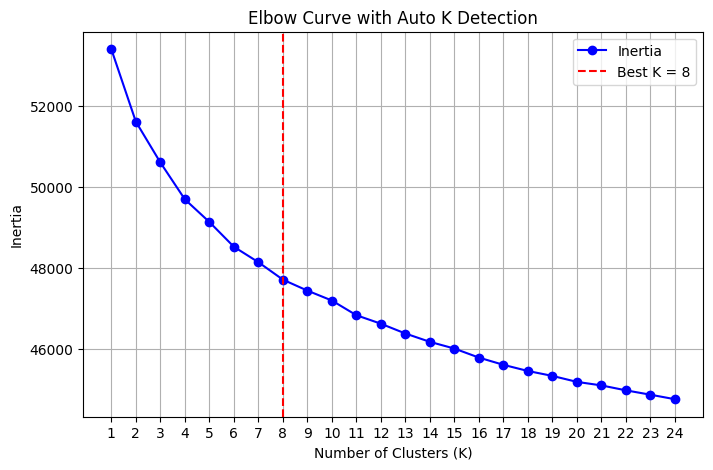

best K: 8
Clustering in progress...
Clustering completed.
Running PCA dimensionality reduction...
PCA completed. Generating plot...


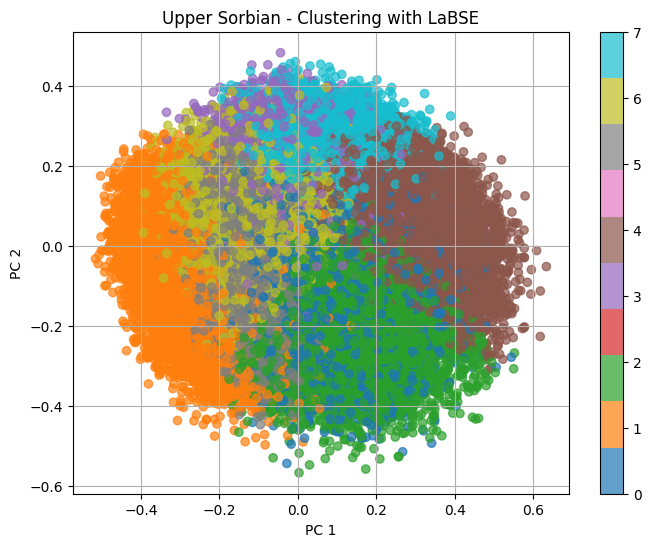

In [ ]:
#最佳k值寻找以及cluster可视化 find optimal k value and visualization

# 加载保存好的嵌入向量 Load pre-saved sentence embeddings
hsb_embeddings = np.load("/content/drive/MyDrive/Colab Notebooks/labse/labse_hsb.npy")  # Upper Sorbian

# 判断最佳K determine optimal k--uppersobian
# 8 is the best k after running
best_k_hsb = elbow_with_kneedle(hsb_embeddings, k_range=range(1, 25))

# 聚类 cluster
hsb_labels = perform_kmeans(hsb_embeddings, n_clusters=best_k_hsb)

# 可视化 visualization
plot_clusters_pca(hsb_embeddings, hsb_labels, "Upper Sorbian - Clustering with LaBSE")


In [ ]:
#hsb best k = 8

hsb_labels, hsb_centroids = perform_kmeans(hsb_embeddings, n_clusters=8)

hsb_metrics = clustering_quality_metrics(hsb_embeddings, hsb_labels, hsb_centroids)
print("Upper Sorbian Metrics:", hsb_metrics)

Clustering in progress...
Clustering completed.
Upper Sorbian Metrics: {'avg_intra_cluster_distance': 0.889972984790802, 'intra_cluster_variance': 0.003007082035765052, 'silhouette_score': 0.02740476466715336, 'avg_inter_cluster_distance': 0.48893335461616516, 'min_inter_cluster_distance': 0.3271399736404419, 'dunn_index': np.float32(0.20622227), 'db_index': 4.7468577826311655}


start calculating KMeans different K value under inertia...
Fitting KMeans for k=1
Fitting KMeans for k=2
Fitting KMeans for k=3
Fitting KMeans for k=4
Fitting KMeans for k=5
Fitting KMeans for k=6
Fitting KMeans for k=7
Fitting KMeans for k=8
Fitting KMeans for k=9
Fitting KMeans for k=10
Fitting KMeans for k=11
Fitting KMeans for k=12
Fitting KMeans for k=13
Fitting KMeans for k=14
Fitting KMeans for k=15
Fitting KMeans for k=16
Fitting KMeans for k=17
Fitting KMeans for k=18
Fitting KMeans for k=19
Fitting KMeans for k=20
Fitting KMeans for k=21
Fitting KMeans for k=22
Fitting KMeans for k=23
Fitting KMeans for k=24


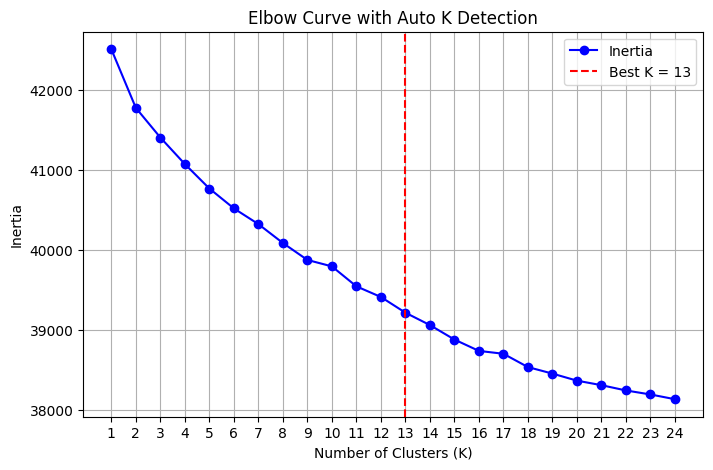

best K: 13
Clustering in progress...
Clustering completed.
Running PCA dimensionality reduction...
PCA completed. Generating plot...


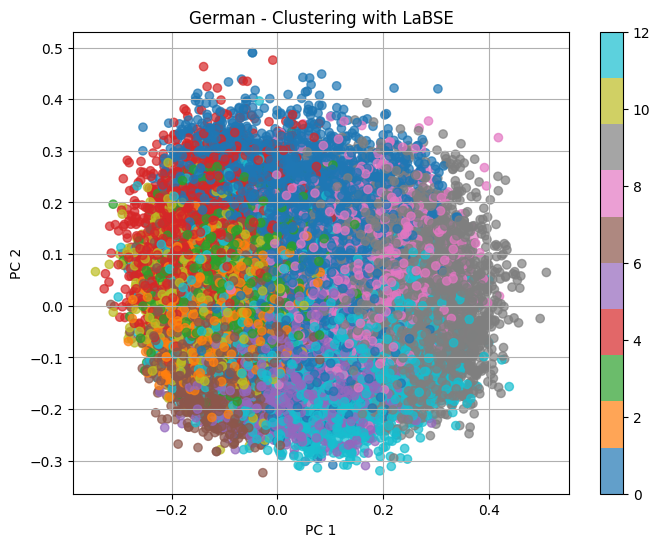

In [ ]:
de_embeddings = np.load("/content/drive/MyDrive/Colab Notebooks/labse/labse_de.npy")    # German

# de
# 13 is the best k after running
best_k_de = elbow_with_kneedle(de_embeddings, k_range=range(1, 25))

de_labels = perform_kmeans(de_embeddings, n_clusters=best_k_de)

plot_clusters_pca(de_embeddings, de_labels, "German - Clustering with LaBSE")

In [ ]:
#de best k = 13

de_labels, de_centroids = perform_kmeans(de_embeddings, n_clusters=13)

de_metrics = clustering_quality_metrics(de_embeddings, de_labels, de_centroids)
print("German Metrics:", de_metrics)

Clustering in progress...
Clustering completed.
German Metrics: {'avg_intra_cluster_distance': 0.8068848252296448, 'intra_cluster_variance': 0.0026035828050225973, 'silhouette_score': 0.01427821721881628, 'avg_inter_cluster_distance': 0.3582105040550232, 'min_inter_cluster_distance': 0.23790870606899261, 'dunn_index': np.float32(0.15464282), 'db_index': 5.747775326018621}


question: check the clusters that you have found to see if the found topic are consistent or not: do they talk about the same kind of theme? What do they have in common?

What I‘m doing: assigning topic labels to each cluster based on TF-IDF score.#stopword spaCy + NLTK




combine spaCy + NLTK

In [ ]:
!pip install -q spacy scikit-learn nltk
!python -m spacy download de_core_news_sm

import spacy
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
# 加载 spaCy 和 NLTK 的德语 stopwords stopwords load stopword of spaCy and NLTK
nlp = spacy.load("de_core_news_sm")
spacy_stopwords = nlp.Defaults.stop_words
nltk_stopwords = set(stopwords.words("german"))
combined_stopwords = spacy_stopwords.union(nltk_stopwords)

# 文本清洗函数：只保留有意义词（长度 > 2、非标点、非数字、非停用词） keep meaningful words
def clean_sentences_combined(sentences):
    cleaned = []
    for doc in nlp.pipe(sentences, batch_size=32):
        tokens = [
            token.lemma_.lower() for token in doc
            if token.is_alpha and not token.is_punct
            and len(token.text) > 2
            and token.lemma_.lower() not in combined_stopwords
            and token.pos_ in {"NOUN", "PROPN", "ADJ"}    # filter verb aux and adv
        ]
        cleaned.append(" ".join(tokens))
    return cleaned

def extract_keywords_by_cluster(df, text_col="sentence", cluster_col="cluster_label", top_n=10):
    cluster_keywords = {}
    grouped = df.groupby(cluster_col)[text_col].apply(list)

    for cluster_id, sentences in grouped.items():
        cleaned = clean_sentences_combined(sentences)
        vectorizer = TfidfVectorizer(
            ngram_range=(1, 2),          #  extract unigram 和 bigram
            max_features=1000,
            min_df=1 #只出现一次也保留
            )
        X = vectorizer.fit_transform(cleaned)
        tfidf_scores = X.sum(axis=0).A1
        words = vectorizer.get_feature_names_out()
        top_indices = tfidf_scores.argsort()[::-1][:top_n]
        top_words = [(words[i], round(tfidf_scores[i], 3)) for i in top_indices]
        cluster_keywords[cluster_id] = top_words

    return cluster_keywords


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 66.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# k=7
df_de = pd.DataFrame({
    "sentence": german_sentences,
    "cluster_label": de_labels
})

# 获取每个 cluster 的句子数 get number of sentences
cluster_sizes = df_de['cluster_label'].value_counts().sort_index()

# 获取每个 cluster 的关键词，可选只保留 bigrams
cluster_keywords = extract_keywords_by_cluster(df_de)

# 打印组合信息
for cid, words in sorted(cluster_keywords.items()):
    count = cluster_sizes.get(cid, 0)
    print(f"\nCluster {cid}: number of sentences = {count}")
    for word, score in words:
        print(f"  {word}: {score}")


Cluster 0: number of sentences = 12058
  kind: 329.377
  neu: 208.369
  schüler: 171.98
  sprache: 163.983
  mensch: 146.187
  schule: 142.145
  arbeit: 120.413
  projekt: 117.539
  eltern: 103.095
  aufgabe: 100.248

Cluster 1: number of sentences = 7618
  bautzen: 191.321
  lausitz: 180.396
  alt: 130.117
  sorbisch: 119.018
  stadt: 98.304
  dorf: 97.497
  neu: 96.507
  freund: 89.616
  oberlausitz: 88.163
  schön: 79.97

Cluster 2: number of sentences = 8581
  kind: 112.61
  haus: 86.163
  neu: 78.46
  mensch: 71.216
  letzter: 58.559
  arbeit: 57.97
  frau: 40.619
  klein: 39.612
  stadt: 39.58
  wort: 38.709

Cluster 3: number of sentences = 11140
  haus: 87.82
  wasser: 87.743
  neu: 78.109
  mensch: 72.539
  arbeit: 65.979
  kind: 65.818
  schön: 48.916
  flasche: 46.289
  stadt: 44.6
  klein: 44.096

Cluster 4: number of sentences = 6469
  domowina: 225.284
  mitglied: 124.688
  vorsitzend: 110.836
  sächsisch: 110.579
  sorbisch: 106.617
  verein: 93.931
  neu: 92.799
  sach

In [ ]:
# k=13
df_de = pd.DataFrame({
    "sentence": german_sentences,
    "cluster_label": de_labels
})

# 获取每个 cluster 的句子数 get number of sentences
cluster_sizes = df_de['cluster_label'].value_counts().sort_index()

# 获取每个 cluster 的关键词
cluster_keywords = extract_keywords_by_cluster(df_de)

# 打印组合信息
for cid, words in cluster_keywords.items():
    count = cluster_sizes[cid]
    print(f"\nCluster {cid}: number of sentences = {count}")
    for word, score in words:
        print(f"  {word}: {score}")



Cluster 0: number of sentences = 5443
  neu: 120.304
  projekt: 80.527
  zukunft: 71.199
  arbeit: 61.363
  ziel: 51.558
  aufgabe: 51.282
  entwicklung: 51.015
  stadt: 49.796
  mensch: 48.852
  frage: 47.496

Cluster 1: number of sentences = 5522
  bautzen: 159.559
  lausitz: 135.085
  alt: 109.284
  sorbisch: 88.957
  freund: 86.989
  oberlausitz: 69.115
  neu: 67.928
  freundin: 66.375
  bautzener: 66.242
  schön: 65.955

Cluster 2: number of sentences = 6962
  mensch: 77.392
  neu: 66.159
  kind: 56.38
  haus: 55.95
  klein: 52.274
  arbeit: 49.543
  stadt: 41.895
  schön: 41.409
  buch: 39.768
  euro: 39.754

Cluster 3: number of sentences = 6380
  kind: 75.788
  haus: 72.943
  neu: 63.128
  mensch: 56.015
  letzter: 51.191
  arbeit: 44.67
  vergangen: 38.737
  klein: 34.661
  stadt: 32.228
  frau: 31.746

Cluster 4: number of sentences = 3644
  kind: 38.407
  wasser: 22.571
  neu: 19.849
  haus: 19.525
  tasche: 18.46
  wind: 17.55
  sorben: 17.358
  mädchen: 16.608
  mutter: 1

In [ ]:
#with cluster_center
#calculate hsb-label

import numpy as np
from sklearn.cluster import KMeans
from google.colab import drive

# 加载保存好的嵌入向量 Load pre-saved sentence embeddings
hsb_embeddings = np.load("/content/drive/MyDrive/Colab Notebooks/labse/labse_hsb.npy")  # Upper Sorbian
de_embeddings = np.load("/content/drive/MyDrive/Colab Notebooks/labse/labse_de.npy")    # German

#kmeans方法用最佳的k值 kmeans using opimal k
def perform_kmeans(embeddings, n_clusters):
    print("Clustering in progress...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(embeddings)
    print("Clustering completed.")
    return labels
# 聚类 cluster 每个句子和对应的cluster
hsb_labels = perform_kmeans(hsb_embeddings, n_clusters=13)
de_labels = perform_kmeans(de_embeddings, n_clusters=13)


Clustering in progress...
Clustering completed.
Clustering in progress...
Clustering completed.


In [ ]:
#detailed edition
from collections import defaultdict, Counter

def compare_cross_lingual_cluster_consistency_full(hsb_labels, de_labels, hsb_sentences, de_sentences):

    cluster_map = defaultdict(list)
    for idx, label in enumerate(hsb_labels):
        cluster_map[label].append(idx)

    report = {}

    for cluster_id, indices in cluster_map.items():
        german_cluster_ids = [de_labels[i] for i in indices]
        german_counts = Counter(german_cluster_ids)
        total = len(german_cluster_ids)

        top_cluster, top_count = german_counts.most_common(1)[0]
        ratio = top_count / total

        percent_dist = {k: f"{(v / total) * 100:.1f}%" for k, v in german_counts.items()}

        report[cluster_id] = {
            "top_german_cluster": top_cluster,
            "consistency_ratio": round(ratio, 2),
            "distribution_full": dict(german_counts),
            "distribution_percent": percent_dist
        }

    return report
def describe_crosslingual_cluster_mapping_full(report: dict):

    for cid, info in sorted(report.items()):
        print(f"\nUpper Sorbian Cluster {cid}:")
        print(f"  → Most mapped to German Cluster {info['top_german_cluster']} "
              f"({info['consistency_ratio']*100:.1f}% of sentences)")
        print(f"  → Full German cluster distribution (percentage): {info['distribution_percent']}")
        print(f"  → Raw distribution: {info['distribution_full']}")

import pandas as pd

def convert_cluster_report_to_dataframe_full(report: dict) -> pd.DataFrame:
    rows = []
    for cid, info in sorted(report.items()):
        row = {
            "Upper_Sorbian_Cluster": cid,
            "Top_German_Cluster": info["top_german_cluster"],
            "Top_Cluster_Ratio": info["consistency_ratio"]
        }

        for gcid, percent in info["distribution_percent"].items():
            row[f"German_Cluster_{gcid}_%"] = percent

        for gcid, count in info["distribution_full"].items():
            row[f"German_Cluster_{gcid}_count"] = count

        rows.append(row)
    return pd.DataFrame(rows)


report = compare_cross_lingual_cluster_consistency_full(hsb_labels, de_labels, sorbian_sentences, german_sentences)


describe_crosslingual_cluster_mapping_full(report)


df = convert_cluster_report_to_dataframe_full(report)
df.to_csv("/content/drive/MyDrive/Colab Notebooks/labse/labse_k_13.csv", index=False)




Upper Sorbian Cluster 0:
  → Most mapped to German Cluster 3 (23.0% of sentences)
  → Full German cluster distribution (percentage): {np.int32(2): '14.9%', np.int32(3): '23.3%', np.int32(0): '18.5%', np.int32(4): '3.1%', np.int32(5): '10.0%', np.int32(12): '8.5%', np.int32(10): '7.3%', np.int32(11): '6.2%', np.int32(8): '2.1%', np.int32(9): '0.4%', np.int32(1): '3.1%', np.int32(7): '2.3%', np.int32(6): '0.2%'}
  → Raw distribution: {np.int32(2): 759, np.int32(3): 1185, np.int32(0): 943, np.int32(4): 158, np.int32(5): 508, np.int32(12): 434, np.int32(10): 370, np.int32(11): 315, np.int32(8): 107, np.int32(9): 19, np.int32(1): 158, np.int32(7): 117, np.int32(6): 11}

Upper Sorbian Cluster 1:
  → Most mapped to German Cluster 9 (41.0% of sentences)
  → Full German cluster distribution (percentage): {np.int32(9): '40.9%', np.int32(8): '19.9%', np.int32(11): '14.0%', np.int32(0): '1.7%', np.int32(5): '10.3%', np.int32(1): '11.2%', np.int32(3): '1.0%', np.int32(12): '0.1%', np.int32(2): '0.

In [ ]:
# install plotly
!pip install plotly

import pandas as pd
import plotly.graph_objects as go

# convert report to DataFrame
def report_to_alluvial_df(report):
    rows = []
    for sorb_cluster, info in report.items():
        for ger_cluster, count in info["distribution_full"].items():
            rows.append({
                "source": f"HSB_{sorb_cluster}",
                "target": f"DE_{ger_cluster}",
                "value": count
            })
    return pd.DataFrame(rows)

df_alluvial = report_to_alluvial_df(report)


labels = list(pd.unique(df_alluvial['source'].tolist() + df_alluvial['target'].tolist()))
label_indices = {label: idx for idx, label in enumerate(labels)}


df_alluvial['source_idx'] = df_alluvial['source'].map(label_indices)
df_alluvial['target_idx'] = df_alluvial['target'].map(label_indices)

# creat Sankey diagramm
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels
    ),
    link=dict(
    source=df_alluvial['source_idx'],
    target=df_alluvial['target_idx'],
    value=df_alluvial['value'],
    label=[str(v) for v in df_alluvial['value']],  # 将每条边的值显示出来
    customdata=[str(v) for v in df_alluvial['value']],
    hovertemplate='Value: %{value}<extra></extra>'
)

)])

fig.update_layout(title_text="Cross-lingual Cluster Mapping(LaBSE)", font_size=10)
fig.show()

html_path = "/content/drive/MyDrive/Colab Notebooks/labse/labse_sankey_output.html"
fig.write_html(html_path)

/tmp/ipython-input-6-191519461.py:24: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  labels = list(pd.unique(df_alluvial['source'].tolist() + df_alluvial['target'].tolist()))


In [ ]:
#calculate hsb-label

import numpy as np
from sklearn.cluster import KMeans
from google.colab import drive

# 加载保存好的嵌入向量 Load pre-saved sentence embeddings
hsb_embeddings = np.load("/content/drive/MyDrive/Colab Notebooks/labse/labse_hsb.npy")  # Upper Sorbian
de_embeddings = np.load("/content/drive/MyDrive/Colab Notebooks/labse/labse_de.npy")    # German

#kmeans方法用最佳的k值 kmeans using opimal k
def perform_kmeans(embeddings, n_clusters):
    print("Clustering in progress...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(embeddings)
    print("Clustering completed.")
    return labels
# 聚类 cluster 每个句子和对应的cluster
hsb_labels = perform_kmeans(hsb_embeddings, n_clusters=12)
de_labels = perform_kmeans(de_embeddings, n_clusters=12)


Clustering in progress...
Clustering completed.
Clustering in progress...
Clustering completed.


calculation evaluation metrics: avg top mapping ratio and entropy

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import Counter
from google.colab import drive

# load Google Drive
drive.mount('/content/drive')

# path
base_path = "/content/drive/MyDrive/Colab Notebooks/labse"

# calculate entropy
def compute_entropy(distribution: dict) -> float:
    counts = np.array(list(distribution.values()))
    probs = counts / counts.sum()
    return round(float(-np.sum(probs * np.log2(probs + 1e-12))), 4)

def summarize_from_csv(file_path: str) -> dict:
    df = pd.read_csv(file_path)
    cluster_cols = [col for col in df.columns if col.endswith("_count")]

    top_ratios = []
    entropies = []

    for _, row in df.iterrows():
        distribution = {
            int(col.split("_")[2]): int(row[col])
            for col in cluster_cols if not pd.isna(row[col])
        }
        if not distribution:
            continue
        top_ratio = max(distribution.values()) / sum(distribution.values())
        entropy = compute_entropy(distribution)
        top_ratios.append(top_ratio)
        entropies.append(entropy)

    return {
        "file": os.path.basename(file_path),
        "avg_top_mapping_ratio": round(np.mean(top_ratios), 4),
        "avg_entropy": round(np.mean(entropies), 4)
    }

#  labse_k_3.csv to labse_k_13.csv
results = []
for k in range(3, 14):
    file_path = os.path.join(base_path, f"labse_k_{k}.csv")
    if os.path.exists(file_path):
        summary = summarize_from_csv(file_path)
        summary["k"] = k
        results.append(summary)

# save
df_summary = pd.DataFrame(results)
print(df_summary)
summary_csv_path = os.path.join(base_path, "labse_k_summary.csv")
df_summary.to_csv(summary_csv_path, index=False)
print(f"Saved summary to: {summary_csv_path}")




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
              file  avg_top_mapping_ratio  avg_entropy   k
0    labse_k_3.csv                 0.5224       1.2823   3
1    labse_k_4.csv                 0.5276       1.5039   4
2    labse_k_5.csv                 0.5998       1.5504   5
3    labse_k_6.csv                 0.4962       1.8048   6
4    labse_k_7.csv                 0.4856       1.9355   7
5    labse_k_8.csv                 0.4631       2.0915   8
6    labse_k_9.csv                 0.4222       2.2554   9
7   labse_k_10.csv                 0.4833       2.1200  10
8   labse_k_11.csv                 0.4800       2.1580  11
9   labse_k_12.csv                 0.4822       2.2567  12
10  labse_k_13.csv                 0.4493       2.3412  13
Saved summary to: /content/drive/MyDrive/Colab Notebooks/labse/labse_k_summary.csv


In [ ]:
import pandas as pd
import os

#  path
base_path = "/content/drive/MyDrive/Colab Notebooks"
paths = {
    "LaBSE": os.path.join(base_path, "labse", "labse_k_summary.csv"),
    "Glot500": os.path.join(base_path, "glot500", "glot500_k_summary.csv"),
    "XLM-R": os.path.join(base_path, "xlm-r", "xlmr_k_summary.csv"),
    "Laser": os.path.join(base_path, "laser", "laser_k_summary.csv")
}

# load model
df_all = pd.DataFrame()
for model_name, path in paths.items():
    df = pd.read_csv(path)
    df["Model"] = model_name
    df_all = pd.concat([df_all, df], ignore_index=True)

def normalize_and_score_across_models(df, alpha=0.5, beta=0.5):
    df = df.copy()

    # normalization：Top Mapping Ratio
    top_min, top_max = df["avg_top_mapping_ratio"].min(), df["avg_top_mapping_ratio"].max()
    df["TopRatio_norm"] = (df["avg_top_mapping_ratio"] - top_min) / (top_max - top_min + 1e-12)

    # normalization：Entropy
    ent_min, ent_max = df["avg_entropy"].min(), df["avg_entropy"].max()
    df["Entropy_norm"] = (df["avg_entropy"] - ent_min) / (ent_max - ent_min + 1e-12)

    # combined score (higher is better)
    df["Combined_Score"] = alpha * df["TopRatio_norm"] + beta * (1 - df["Entropy_norm"])

    df_sorted = df.sort_values(by=["k", "Combined_Score"], ascending=[True, False])

    return df_sorted

In [ ]:
df_scored = normalize_and_score_across_models(df_all, alpha=0.5, beta=0.5)
output_path = os.path.join(base_path, "all_model_k_ranked.csv")
df_scored.to_csv(output_path, index=False)
print(f"Saved to: {output_path}")
df_scored.head()


Saved to: /content/drive/MyDrive/Colab Notebooks/all_model_k_ranked.csv


,file,avg_top_mapping_ratio,avg_entropy,k,Model,TopRatio_norm,Entropy_norm,Combined_Score
33,laser_k_3.csv,0.7979,0.8156,3,Laser,1.000000,0.000000,1.000000
11,glot500_k_3.csv,0.7313,0.9528,3,Glot500,0.865509,0.076537,0.894486
22,xlmr_k_3.csv,0.7030,0.9603,3,XLM-R,0.808360,0.080721,0.863820
0,labse_k_3.csv,0.5224,1.2823,3,LaBSE,0.443659,0.260348,0.591656
12,glot500_k_4.csv,0.6396,1.1881,4,Glot500,0.680331,0.207799,0.736266


plot the combined score of the 4 models

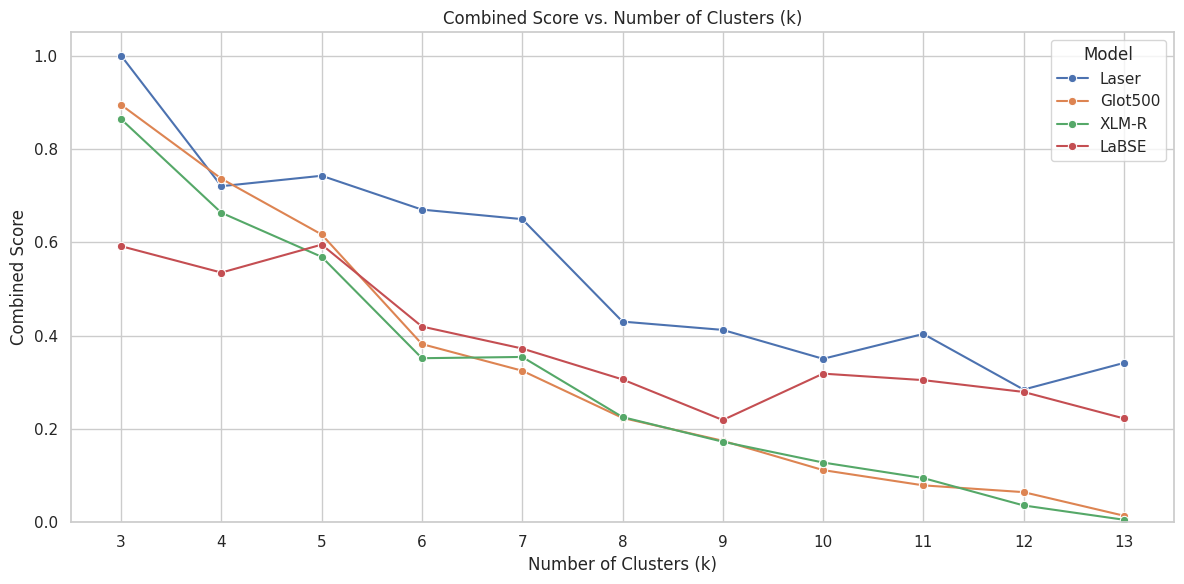

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


csv_path = "/content/drive/MyDrive/Colab Notebooks/all_model_k_ranked.csv"

df = pd.read_csv(csv_path)


if "Combined_Score" not in df.columns:
    def normalize_and_score_across_models(df, alpha=0.5, beta=0.5):
        df = df.copy()
        top_min, top_max = df["avg_top_mapping_ratio"].min(), df["avg_top_mapping_ratio"].max()
        df["TopRatio_norm"] = (df["avg_top_mapping_ratio"] - top_min) / (top_max - top_min + 1e-12)
        ent_min, ent_max = df["avg_entropy"].min(), df["avg_entropy"].max()
        df["Entropy_norm"] = (df["avg_entropy"] - ent_min) / (ent_max - ent_min + 1e-12)
        df["Combined_Score"] = alpha * df["TopRatio_norm"] + beta * (1 - df["Entropy_norm"])
        return df

    df = normalize_and_score_across_models(df)


sns.set(style="whitegrid")

# plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="k", y="Combined_Score", hue="Model", marker="o")
plt.title("Combined Score vs. Number of Clusters (k)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Combined Score")
plt.xticks(sorted(df["k"].unique()))
plt.ylim(0, 1.05)
plt.legend(title="Model")
plt.tight_layout()
plt.show()


t-SNE visualization without cbie

<ipython-input-10-5f4db0d921be>:54: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(all_embs_tsne[:3000, 0], all_embs_tsne[:3000, 1], c=colors[0], s=10, label="German")
<ipython-input-10-5f4db0d921be>:55: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(all_embs_tsne[3000:, 0], all_embs_tsne[3000:, 1], c=colors[2], s=10, label="Upper Sorbian")


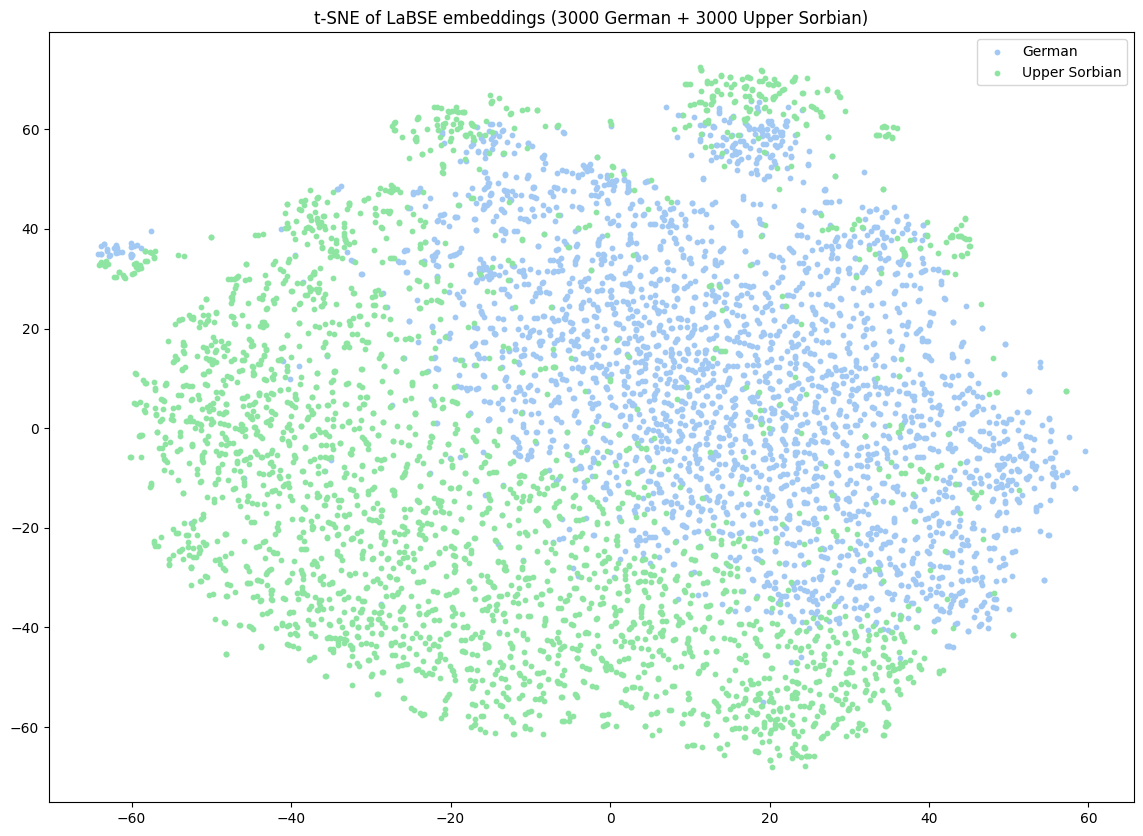

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

def smart_sample(embeddings: np.ndarray, n_samples: int = 3000, n_clusters: int = 7) -> np.ndarray:
    pca = PCA(n_components=50)
    emb_pca = pca.fit_transform(embeddings)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_ids = kmeans.fit_predict(emb_pca)

    sampled_indices = []
    for cluster_id in range(n_clusters):
        cluster_indices = np.where(cluster_ids == cluster_id)[0]
        n = len(cluster_indices)
        if n == 0:
            continue
        n_to_sample = int(np.round(n_samples * n / len(embeddings)))
        n_to_sample = min(n_to_sample, n)
        sampled = np.random.choice(cluster_indices, size=n_to_sample, replace=False)#randomly every time
        sampled_indices.extend(sampled)

    return np.array(sampled_indices[:n_samples])  # 保证刚好 n_samples 个

# load dataset
hsb_embeddings = np.load("/content/drive/MyDrive/Colab Notebooks/labse/labse_hsb.npy")
de_embeddings = np.load("/content/drive/MyDrive/Colab Notebooks/labse/labse_de.npy")

# sample
hsb_idx = smart_sample(hsb_embeddings, n_samples=3000)
de_idx = smart_sample(de_embeddings, n_samples=3000)

hsb_sampled = hsb_embeddings[hsb_idx]
de_sampled = de_embeddings[de_idx]

# concatenate + reduction diemension
all_embs = np.concatenate([de_sampled, hsb_sampled])
pca = PCA(n_components=50)
all_embs_pca = pca.fit_transform(all_embs)

tsne = TSNE(n_components=2, random_state=42)
all_embs_tsne = tsne.fit_transform(all_embs_pca)

# visualization
colors = sns.color_palette("pastel", 8)
n_de = len(de_sampled)
n_hsb = len(hsb_sampled)
c = [colors[0]] * n_de + [colors[2]] * n_hsb

plt.figure(figsize=(14, 10))
plt.scatter(all_embs_tsne[:3000, 0], all_embs_tsne[:3000, 1], c=colors[0], s=10, label="German")
plt.scatter(all_embs_tsne[3000:, 0], all_embs_tsne[3000:, 1], c=colors[2], s=10, label="Upper Sorbian")
plt.title("t-SNE of LaBSE embeddings (3000 German + 3000 Upper Sorbian)")
plt.legend()
plt.savefig("tsne_3000_each.png", dpi=300, bbox_inches="tight")
plt.show()



t-SNE visualization with cbie

<ipython-input-4-b94396ce7b98>:102: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(all_embs_tsne[:3000, 0], all_embs_tsne[:3000, 1], c=colors[0], s=10, label="German (CBIE)")
<ipython-input-4-b94396ce7b98>:103: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(all_embs_tsne[3000:, 0], all_embs_tsne[3000:, 1], c=colors[2], s=10, label="Upper Sorbian (CBIE)")


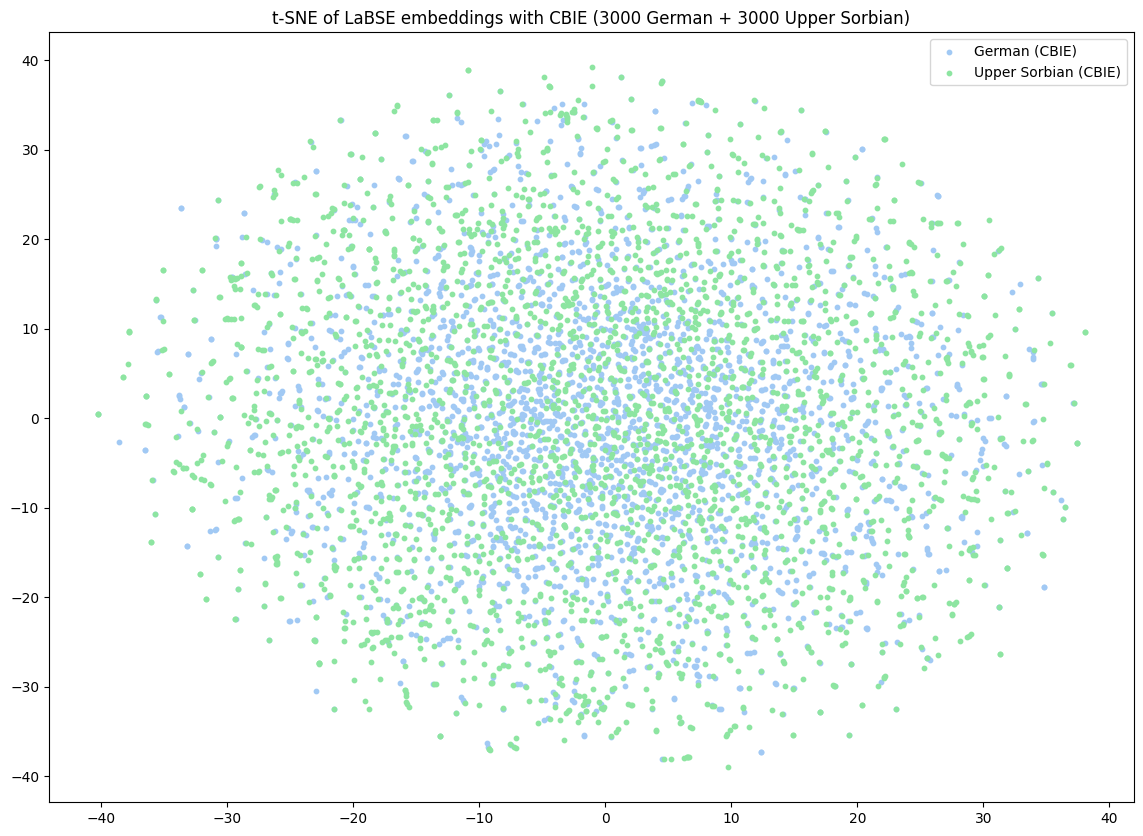

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

#cluster_based() from citation code
def cluster_based(representations, n_cluster: int, n_pc: int, hidden_size: int = 768):
    from scipy import cluster as clst

    centroids, labels = clst.vq.kmeans2(representations, n_cluster, minit='points', missing='warn', check_finite=True)
    cluster_means = []
    for i in range(max(labels) + 1):
        summ = np.zeros([1, hidden_size])
        for j in np.nonzero(labels == i)[0]:
            summ = np.add(summ, representations[j])
        cluster_means.append(summ / len(labels[labels == i]))

    zero_mean_representations = []
    for i in range(len(representations)):
        zero_mean_representations.append((representations[i]) - cluster_means[labels[i]])

    cluster_representations = {}
    for i in range(n_cluster):
        cluster_representations.update({i: {}})
        for j in range(len(representations)):
            if labels[j] == i:
                cluster_representations[i].update({j: zero_mean_representations[j]})

    cluster_representations2 = []
    for j in range(n_cluster):
        cluster_representations2.append([])
        for key, value in cluster_representations[j].items():
            cluster_representations2[j].append(value)

    model = PCA()
    post_rep = np.zeros((representations.shape[0], representations.shape[1]))

    for i in range(n_cluster):
        model.fit(np.array(cluster_representations2[i]).reshape((-1, hidden_size)))
        component = np.reshape(model.components_, (-1, hidden_size))

        for index in cluster_representations[i]:
            sum_vec = np.zeros((1, hidden_size))

            for j in range(min(n_pc, component.shape[0])):
                sum_vec = sum_vec + np.dot(cluster_representations[i][index],
                                           np.expand_dims(np.transpose(component)[:, j], 1)) * component[j]

            post_rep[index] = cluster_representations[i][index] - sum_vec

    return post_rep

# smart_sample
def smart_sample(embeddings: np.ndarray, n_samples: int = 3000, n_clusters: int = 7) -> np.ndarray:
    pca = PCA(n_components=50)
    emb_pca = pca.fit_transform(embeddings)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_ids = kmeans.fit_predict(emb_pca)

    sampled_indices = []
    for cluster_id in range(n_clusters):
        cluster_indices = np.where(cluster_ids == cluster_id)[0]
        n = len(cluster_indices)
        if n == 0:
            continue
        n_to_sample = int(np.round(n_samples * n / len(embeddings)))
        n_to_sample = min(n_to_sample, n)
        sampled = np.random.choice(cluster_indices, size=n_to_sample, replace=False)
        sampled_indices.extend(sampled)

    return np.array(sampled_indices[:n_samples])

# Load data
hsb_embeddings = np.load("/content/drive/MyDrive/Colab Notebooks/labse/labse_hsb.npy")
de_embeddings = np.load("/content/drive/MyDrive/Colab Notebooks/labse/labse_de.npy")

# Sample
hsb_idx = smart_sample(hsb_embeddings, n_samples=3000)
de_idx = smart_sample(de_embeddings, n_samples=3000)

hsb_sampled = hsb_embeddings[hsb_idx]
de_sampled = de_embeddings[de_idx]

# Apply CBIE
hsb_cbie = cluster_based(hsb_sampled, n_cluster=7, n_pc=12, hidden_size=hsb_sampled.shape[1])
de_cbie = cluster_based(de_sampled, n_cluster=7, n_pc=12, hidden_size=de_sampled.shape[1])

# Concatenate and visualize with t-SNE
all_embs = np.concatenate([de_cbie, hsb_cbie])
pca = PCA(n_components=50)
all_embs_pca = pca.fit_transform(all_embs)

tsne = TSNE(n_components=2, random_state=42)
all_embs_tsne = tsne.fit_transform(all_embs_pca)

# Plotting
colors = sns.color_palette("pastel", 8)
plt.figure(figsize=(14, 10))
plt.scatter(all_embs_tsne[:3000, 0], all_embs_tsne[:3000, 1], c=colors[0], s=10, label="German (CBIE)")
plt.scatter(all_embs_tsne[3000:, 0], all_embs_tsne[3000:, 1], c=colors[2], s=10, label="Upper Sorbian (CBIE)")
plt.title("t-SNE of LaBSE embeddings with CBIE (3000 German + 3000 Upper Sorbian)")
plt.legend()
plt.show()


umap visualization without cbie



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
<ipython-input-14-eed335c14664>:25: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(all_embs_umap[:3000, 0], all_embs_umap[:3000, 1], c=colors[0], s=10, label="German")
<ipython-input-14-eed335c14664>:26: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence 

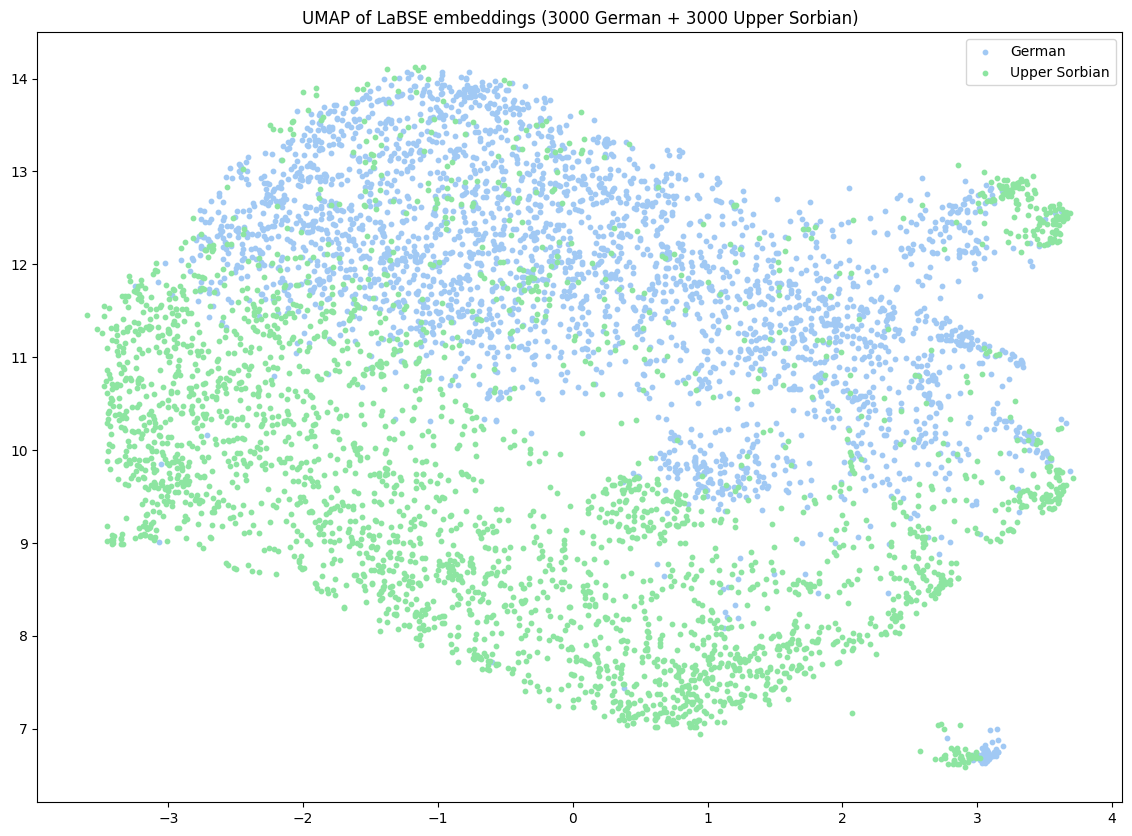

In [ ]:
!pip install umap-learn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap

# 合并嵌入 concatenate
all_embs = np.concatenate([de_sampled, hsb_sampled])

# UMAP 降维 reduce dims
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
all_embs_umap = reducer.fit_transform(all_embs)

# first 3000 is German，the latter is Upper Sorbian
c = [colors[0]] * 3000 + [colors[2]] * 3000
c = c[:all_embs_umap.shape[0]]

# plot
plt.figure(figsize=(14, 10))
plt.scatter(all_embs_umap[:3000, 0], all_embs_umap[:3000, 1], c=colors[0], s=10, label="German")
plt.scatter(all_embs_umap[3000:, 0], all_embs_umap[3000:, 1], c=colors[2], s=10, label="Upper Sorbian")
plt.title("UMAP of LaBSE embeddings (3000 German + 3000 Upper Sorbian)")
plt.legend()
plt.show()



umap visualization with cbie

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
<ipython-input-6-249731fd6864>:24: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(all_embs_umap[:3000, 0], all_embs_umap[:3000, 1], c=colors[0], s=10, label="German")
<ipython-input-6-249731fd6864>:25: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in

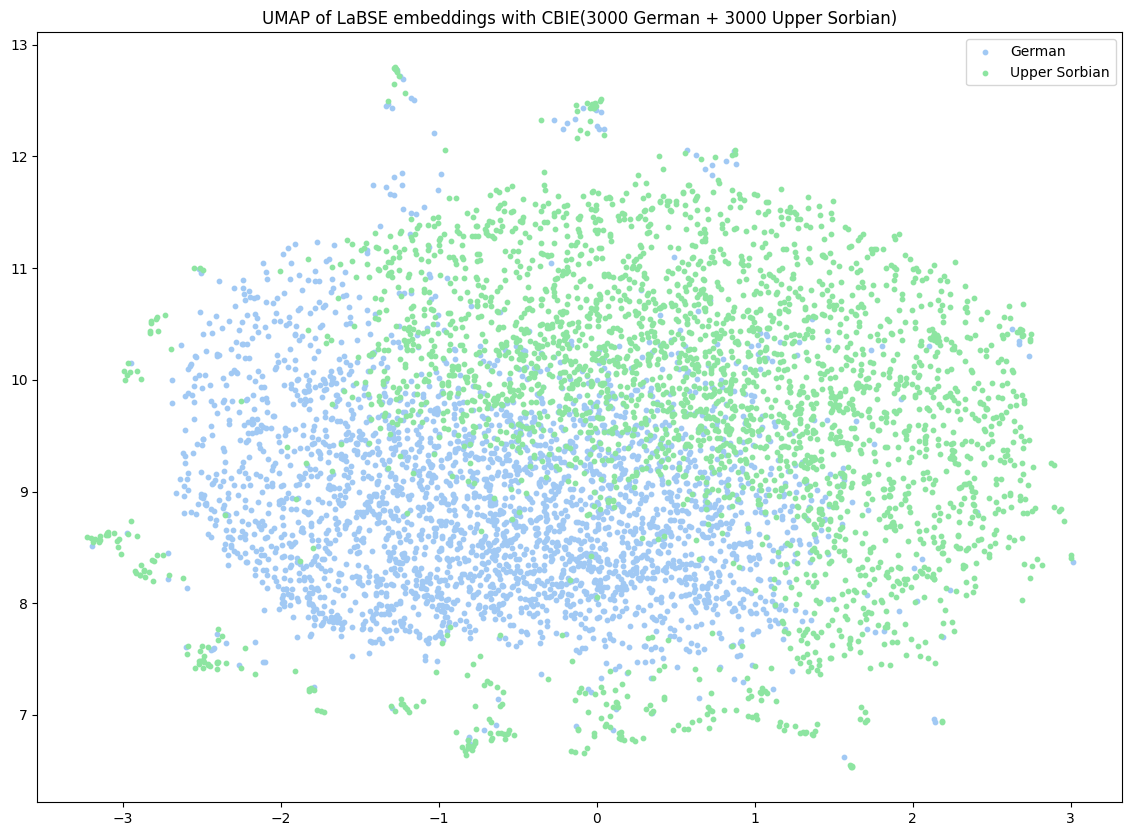

In [ ]:
!pip install umap-learn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap

# 合并嵌入 concatenate
all_embs = np.concatenate([de_cbie, hsb_cbie])

# UMAP 降维 reduce dims
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
all_embs_umap = reducer.fit_transform(all_embs)

# 颜色：前 3000 是 German，后 3000 是 Upper Sorbian
c = [colors[0]] * 3000 + [colors[2]] * 3000
c = c[:all_embs_umap.shape[0]]

# 绘图 plot
plt.figure(figsize=(14, 10))
plt.scatter(all_embs_umap[:3000, 0], all_embs_umap[:3000, 1], c=colors[0], s=10, label="German")
plt.scatter(all_embs_umap[3000:, 0], all_embs_umap[3000:, 1], c=colors[2], s=10, label="Upper Sorbian")
plt.title("UMAP of LaBSE embeddings with CBIE(3000 German + 3000 Upper Sorbian)")
plt.legend()

plt.show()



lda extract topic

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd
!pip install -q spacy nltk
!python -m spacy download de_core_news_sm
import spacy
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# load + stopword
nlp = spacy.load("de_core_news_sm")
combined_stopwords = nlp.Defaults.stop_words.union(set(stopwords.words("german")))


def extract_lda_topics_by_cluster(
    sentences, labels, n_topics=1, n_words=10, ngram_range=(1, 2), max_features=1000, min_df=1
):

    df = pd.DataFrame({
        "sentence": sentences,
        "cluster_label": labels
    })

    cluster_topics = {}

    for cid in sorted(df['cluster_label'].unique()):
        cluster_sents = df[df['cluster_label'] == cid]['sentence'].tolist()
        if len(cluster_sents) < 3:
            continue  # 太少数据不跑 LDA do not run LDA if too less data

        vectorizer = CountVectorizer(
            ngram_range=ngram_range,
            max_features=max_features,
            min_df=min_df
        )
        X = vectorizer.fit_transform(cluster_sents)
        if X.shape[1] == 0:
            cluster_topics[cid] = ["(no valid terms)"]
            continue

        lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
        lda.fit(X)
        feature_names = vectorizer.get_feature_names_out()

        topic_keywords = []
        for topic_idx, topic in enumerate(lda.components_):
            top_indices = topic.argsort()[:-n_words - 1:-1]
            topic = topic / topic.sum()
            top_words = [(feature_names[i], topic[i]) for i in top_indices]
            topic_keywords.extend(top_words)


        cluster_topics[cid] = topic_keywords

    return cluster_topics

def clean_sentences_combined(sentences):
    cleaned = []
    for doc in nlp.pipe(sentences, batch_size=32):
        tokens = [
            token.lemma_.lower() for token in doc
            if token.is_alpha and not token.is_punct
            and len(token.text) > 2
            and token.lemma_.lower() not in combined_stopwords
            and token.pos_ in {"NOUN", "PROPN", "ADJ"}
        ]
        cleaned.append(" ".join(tokens))
    return cleaned


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 91.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
german_sentences_cleaned= clean_sentences_combined(german_sentences)

topics = extract_lda_topics_by_cluster(
    sentences=german_sentences_cleaned,
    labels=de_labels,
    n_topics=1,
    n_words=10
)

# print result
for cid, topic_info in topics.items():
    print(f"\nCluster {cid}:")
    for word, prob in topic_info:  # 每项是 (word, probability) probability of that word occurring in the topic
        print(f"  {word}: {prob:.4f}")



Cluster 0:
  neu: 0.0206
  projekt: 0.0107
  zukunft: 0.0106
  arbeit: 0.0082
  entwicklung: 0.0069
  stadt: 0.0067
  ziel: 0.0067
  region: 0.0066
  mensch: 0.0066
  wichtig: 0.0065

Cluster 1:
  bautzen: 0.0247
  lausitz: 0.0170
  sorbisch: 0.0160
  alt: 0.0144
  neu: 0.0096
  bautzener: 0.0093
  oberlausitz: 0.0084
  freund: 0.0083
  schön: 0.0083
  stadt: 0.0078

Cluster 2:
  mensch: 0.0124
  neu: 0.0123
  klein: 0.0088
  kind: 0.0082
  haus: 0.0075
  arbeit: 0.0068
  euro: 0.0066
  stadt: 0.0066
  schön: 0.0065
  welt: 0.0055

Cluster 3:
  haus: 0.0115
  kind: 0.0106
  neu: 0.0105
  letzter: 0.0090
  mensch: 0.0088
  vergangen: 0.0073
  arbeit: 0.0064
  klein: 0.0061
  frau: 0.0053
  woche: 0.0048

Cluster 4:
  kind: 0.0096
  tasche: 0.0063
  wasser: 0.0059
  haus: 0.0054
  neu: 0.0050
  sorben: 0.0047
  wind: 0.0045
  alt: 0.0043
  mädchen: 0.0041
  mutter: 0.0041

Cluster 5:
  mensch: 0.0106
  neu: 0.0102
  stadt: 0.0075
  arbeit: 0.0065
  region: 0.0062
  sprache: 0.0059
  min

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
import numpy as np

# keywords
topic_keywords = {
    "development": {"neu", "projekt", "zukunft", "arbeit", "entwicklung", "ziel", "stadt"},
    "local_identity": {"bautzen", "lausitz", "sorbisch", "oberlausitz", "freund", "bautzener"},
    "org_politics": {"domowina", "mitglied", "sachsen", "verein", "bundesvorstand"},
    "culture_language": {"sorbisch", "sprache", "kultur", "volk", "institut", "deutsch"},
    "religion_faith": {"gott", "herr", "jesus", "christus", "geist", "himmel"},
    "education": {"kind", "schule", "schüler", "lehrer", "klasse", "eltern"},
    "household_life": { "kind", "kinder", "mensch", "haus", "wohnung", "familie", "mutter", "vater",
    "mädchen", "junge", "baby", "essen", "trinken", "bett", "zimmer", "stuhl",
    "fenster", "tisch", "milch", "wasser", "brot", "spiel", "leben", "frau", "mann"},
    "nature_environment" : {"baum", "wind", "wasser", "luft", "erde", "regen", "wiese", "natur", "pflanze", "blume"}
}

# classification
min_keywords = 2
N = 60  # initial number of sentences
topic_sentences = {topic: [] for topic in topic_keywords}
topic_sentences["Others"] = []


for sent in german_sentences:
    words = set(sent.lower().split())
    matched = False
    for topic, keywords in topic_keywords.items():
        if len(words & keywords) >= min_keywords:
            topic_sentences[topic].append(sent)
            matched = True
    if not matched:
        topic_sentences["Others"].append(sent)

#  keep top n sentences per topic
for topic in topic_sentences:
    if topic != "Others":
        topic_sentences[topic] = topic_sentences[topic][:N]

# load model + Others
model = SentenceTransformer('sentence-transformers/LaBSE')

topic_centroids = {}
for topic in topic_keywords:
    embs = model.encode(topic_sentences[topic], convert_to_numpy=True, show_progress_bar=False)
    topic_centroids[topic] = np.mean(embs, axis=0)

others_sentences = topic_sentences["Others"]
others_embeddings = model.encode(others_sentences, convert_to_numpy=True, show_progress_bar=True)

# assign sentences of other regarding similarity
newly_labeled = {topic: [] for topic in topic_keywords}
still_others = []

for i, emb in enumerate(others_embeddings):
    sims = {topic: cosine_similarity([emb], [centroid])[0][0] for topic, centroid in topic_centroids.items()}
    best_topic, best_score = max(sims.items(), key=lambda x: x[1])
    if best_score > 0.5:
        newly_labeled[best_topic].append(others_sentences[i])
    else:
        still_others.append(others_sentences[i])

# max per topic 150, other keep 150
max_per_topic = 150
final_topic_sentences = defaultdict(list)

for topic in topic_keywords:
    combined = topic_sentences[topic] + newly_labeled[topic]
    final_topic_sentences[topic] = combined[:max_per_topic]

final_topic_sentences["Others"] = still_others[:150]

# output
for topic, sents in final_topic_sentences.items():
    print(f"{topic}: {len(sents)} sentences")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

2_Dense/model.safetensors:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

2_Dense/pytorch_model.bin:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

Batches:   0%|          | 0/1844 [00:00<?, ?it/s]

development: 150 sentences
local_identity: 150 sentences
org_politics: 150 sentences
culture_language: 150 sentences
religion_faith: 150 sentences
education: 150 sentences
household_life: 150 sentences
nature_environment: 150 sentences
Others: 150 sentences


visualization dataset

Batches:   0%|          | 0/43 [00:00<?, ?it/s]

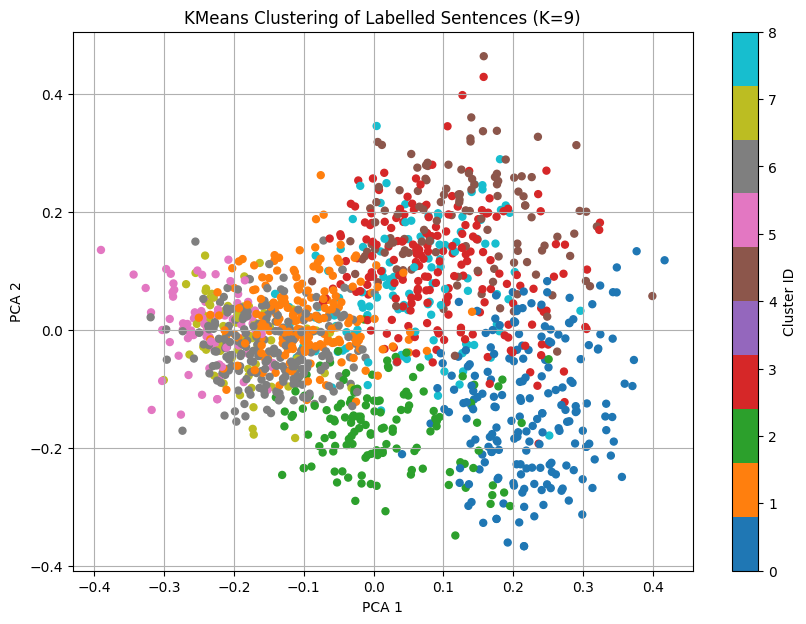

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np


sentences = []
true_labels = []
for topic, sents in final_topic_sentences.items():
    sentences.extend(sents)
    true_labels.extend([topic] * len(sents))

# embedding
model = SentenceTransformer("sentence-transformers/LaBSE")
embeddings = model.encode(sentences, convert_to_numpy=True, show_progress_bar=True)

# KMeans
kmeans = KMeans(n_clusters=9, random_state=42)
cluster_ids = kmeans.fit_predict(embeddings)

# PCA dims to 2D
pca = PCA(n_components=2, random_state=42)
reduced_embeddings = pca.fit_transform(embeddings)

# plot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    reduced_embeddings[:, 0], reduced_embeddings[:, 1],
    c=cluster_ids, cmap='tab10', s=25
)
plt.title("KMeans Clustering of Labelled Sentences (K=9)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(scatter, label="Cluster ID")
plt.grid(True)
plt.show()


In [ ]:
# from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sentence_transformers import SentenceTransformer
import numpy as np

# train set
texts, labels = [], []
for topic, sents in final_topic_sentences.items():
    texts.extend(sents)
    labels.extend([topic] * len(sents))

# embedding
print("Loading embedding model...")
model = SentenceTransformer('sentence-transformers/LaBSE')

print("Encoding sentences...")
embeddings = model.encode(texts, convert_to_numpy=True, show_progress_bar=True)

# split train set and test set
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=42, stratify=labels)




Loading embedding model...
Encoding sentences...


Batches:   0%|          | 0/43 [00:00<?, ?it/s]

logistic regression

In [ ]:
# 4. train classifier
clf = LogisticRegression(C=1.217, max_iter=1000, multi_class='multinomial', solver='lbfgs')
clf.fit(X_train, y_train)

# 5. predict + evaluation
y_pred = clf.predict(X_test)
print("Evaluation report:")
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Evaluation report:
                    precision    recall  f1-score   support

            Others       0.92      0.73      0.81        30
  culture_language       0.90      0.87      0.88        30
       development       0.86      0.80      0.83        30
         education       0.93      0.93      0.93        30
    household_life       0.92      0.77      0.84        30
    local_identity       0.82      0.93      0.88        30
nature_environment       0.83      0.97      0.89        30
      org_politics       0.91      0.97      0.94        30
    religion_faith       0.91      1.00      0.95        30

          accuracy                           0.89       270
         macro avg       0.89      0.89      0.88       270
      weighted avg       0.89      0.89      0.88       270



In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from scipy.stats import loguniform

param_dist = {
    'C': loguniform(1e-3, 1e3)  # random sampled
}

# initialization
clf = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial')

# random search
random_search = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    verbose=1
)
from sklearn.preprocessing import LabelEncoder

# fit labek
le = LabelEncoder()
y_enc = le.fit_transform(labels)

random_search.fit(embeddings, y_enc)

# print
print("Best C (random search):", random_search.best_params_)
print("Best CV Accuracy:", round(random_search.best_score_, 4))


Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best C (random search): {'C': np.float64(1.2173252504194043)}
Best CV Accuracy: 0.8541


randomforest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# train Random Forest
rf_clf = RandomForestClassifier(
    n_estimators=289,
    max_depth=25,
    max_features='log2',
    min_samples_split=8,
    random_state=42
)
rf_clf.fit(X_train, y_train)


rf_pred = rf_clf.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_pred))


Random Forest Classification Report:
                    precision    recall  f1-score   support

            Others       0.80      0.53      0.64        30
  culture_language       0.71      0.80      0.75        30
       development       0.80      0.67      0.73        30
         education       0.86      0.83      0.85        30
    household_life       0.79      0.63      0.70        30
    local_identity       0.81      0.83      0.82        30
nature_environment       0.78      0.93      0.85        30
      org_politics       0.82      0.93      0.88        30
    religion_faith       0.78      0.97      0.87        30

          accuracy                           0.79       270
         macro avg       0.79      0.79      0.79       270
      weighted avg       0.79      0.79      0.79       270



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# 定义搜索空间（随机分布）
param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': [None] + list(range(5, 31, 5)),
    'min_samples_split': randint(2, 10),
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=30,               # 搜索30组组合
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(embeddings, y_enc)
print("Best Random Forest Parameters (Randomized):", random_search.best_params_)
print("Best CV Accuracy:", round(random_search.best_score_, 4))


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Random Forest Parameters (Randomized): {'max_depth': 25, 'max_features': 'log2', 'min_samples_split': 8, 'n_estimators': 289}
Best CV Accuracy: 0.7867


xgboost

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# 标签编码
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

xgb_clf = XGBClassifier(
    learning_rate=0.12319939418114051,
    max_depth=4,
    n_estimators=120,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)
xgb_clf.fit(X_train, y_train_enc)

# 预测
xgb_pred_enc = xgb_clf.predict(X_test)
xgb_pred = le.inverse_transform(xgb_pred_enc)

# 评估
from sklearn.metrics import classification_report
print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_pred))



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:16:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classification Report:
                    precision    recall  f1-score   support

            Others       0.76      0.73      0.75        30
  culture_language       0.76      0.73      0.75        30
       development       0.60      0.60      0.60        30
         education       0.68      0.77      0.72        30
    household_life       0.79      0.63      0.70        30
    local_identity       0.88      0.77      0.82        30
nature_environment       0.69      0.83      0.76        30
      org_politics       0.81      0.87      0.84        30
    religion_faith       0.90      0.90      0.90        30

          accuracy                           0.76       270
         macro avg       0.76      0.76      0.76       270
      weighted avg       0.76      0.76      0.76       270



In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from scipy.stats import randint, uniform

# preparation labels
le = LabelEncoder()
y_enc = le.fit_transform(labels)

# model + paramater space
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

param_dist = {
    'n_estimators': randint(100, 150),
    'max_depth': randint(4, 6),
    'learning_rate': uniform(0.05, 0.1),
}

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=5,
    scoring='accuracy',
    cv=5,
    random_state=42,
    verbose=1,
    n_jobs=-1
)

random_search.fit(embeddings, y_enc)
print("Best XGBoost Parameters:", random_search.best_params_)
print("Best CV Accuracy:", round(random_search.best_score_, 4))


Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:16:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best XGBoost Parameters: {'learning_rate': np.float64(0.12319939418114051), 'max_depth': 4, 'n_estimators': 120}
Best CV Accuracy: 0.737


5-fold cross validation

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import numpy as np

le = LabelEncoder()
y_enc = le.fit_transform(labels)

#  Logistic Regression
logreg =  LogisticRegression(C=1.217, max_iter=1000, multi_class='multinomial', solver='lbfgs')
log_scores = cross_val_score(logreg, embeddings, y_enc, cv=5, scoring='accuracy')

#  Random Forest
rf = RandomForestClassifier(
    n_estimators=289,
    max_depth=25,
    max_features='log2',
    min_samples_split=8,
    random_state=42
)
rf_scores = cross_val_score(rf, embeddings, y_enc, cv=5, scoring='accuracy')

# XGBoost
xgb =XGBClassifier(
    learning_rate=0.123,
    max_depth=4,
    n_estimators=120,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)
xgb_scores = cross_val_score(xgb, embeddings, y_enc, cv=5, scoring='accuracy')

# print
print("Cross-Validation Accuracy (5-fold):")
print(f"Logistic Regression: {log_scores.mean():.4f} ± {log_scores.std():.4f}")
print(f"Random Forest      : {rf_scores.mean():.4f} ± {rf_scores.std():.4f}")
print(f"XGBoost            : {xgb_scores.mean():.4f} ± {xgb_scores.std():.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

Cross-Validation Accuracy (5-fold):
Logistic Regression: 0.8541 ± 0.0125
Random Forest      : 0.7867 ± 0.0168
XGBoost            : 0.7459 ± 0.0365


In [ ]:
#label all of de-sentences
#load
all_de_embeddings = np.load("/content/drive/MyDrive/Colab Notebooks/labse/labse_de.npy")


# model trained before
predicted_labels = clf.predict(all_de_embeddings)

# save to DataFrame
import pandas as pd
df = pd.DataFrame({
    "de_sentence": german_sentences,
    "predicted_label": predicted_labels
})
df.to_csv("/content/drive/MyDrive/Colab Notebooks/labse/de_labeled_sentences.csv", index=False)


In [ ]:
topic_distribution = df["predicted_label"].value_counts()
print(topic_distribution)

predicted_label
Others                15940
household_life        12590
development            6765
education              5388
culture_language       4658
local_identity         3867
org_politics           3779
nature_environment     3722
religion_faith         3291
Name: count, dtype: int64


In [ ]:
import pandas as pd

# random sampled
sample_per_topic = (
    df.groupby("predicted_label")
    .sample(n=5, random_state=42)
    .sort_values("predicted_label")
)

# print
for topic in sorted(sample_per_topic["predicted_label"].unique()):
    print(f"\n=== Topic: {topic} ===")
    for sent in sample_per_topic[sample_per_topic["predicted_label"] == topic]["de_sentence"]:
        print(f"- {sent}")



=== Topic: Others ===
- Ein Wallfahrer denkt über eine fehlende starke Symbolik für die Anwesenden am Pfingstmontag auf der Wallfahrtswiese nach.

- Er sieht wie ein Kutscher aus.

- Wenn ich mich nicht täusche, hat es geklingelt.

- Die Konzentrierung schreitet jedoch voran.

- Bist du pro oder kontra?


=== Topic: culture_language ===
- Bis zum Ende des 20. Jahrhunderts war hier ein freier, unbebauter Platz, auf welchem Festivals der Sorbischen Kultur stattfanden.

- Die CD „Sorbisch leicht – Sorbische Redewendungen für den Alltag“ wendet sich an Sorbischlernende und an Interessen, die sich beim Besuch der sorbischen Lausitz auch ein wenig der obersorbischen Sprache bedienen möchten.

- Die Erzieherin bietet den Kindern sorbische Laut-, Reim- und Silbenspiele, sprachrhythmische Spiele, Wortbildungsspiele, Fingerspiele usw. an, was das Sprachgefühl der Kinder für das Sorbische stärkt und ihnen Freude am Spiel mit der Sprache bereitet.

- Die Nähe zu den Bürgern durch den Kontakt im S

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
from scipy.stats import randint, uniform, loguniform

# 1. load HSB embedding and projected labels
hsb_embeddings = np.load("/content/drive/MyDrive/Colab Notebooks/labse/labse_hsb.npy")
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/labse/de_labeled_sentences.csv")
projected_labels = df["predicted_label"].tolist()

# 2. labelencoder
le = LabelEncoder()
y = le.fit_transform(projected_labels)





In [ ]:
# Logistic Regression

lr = LogisticRegression(max_iter=100, solver='lbfgs', multi_class='multinomial')
param_dist_lr = {
    'C': loguniform(1e-2, 1e2)
}
rs_lr = RandomizedSearchCV(lr, param_dist_lr, n_iter=10, cv=3, scoring='accuracy', random_state=42, verbose=0, n_jobs=-1)
rs_lr.fit(hsb_embeddings, y)

print("=== Logistic Regression ===")
print("Best Accuracy:", rs_lr.best_score_)
print("Best Params :", rs_lr.best_params_)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


=== Logistic Regression ===
Best Accuracy: 0.5991666666666667
Best Params : {'C': np.float64(2.481040974867813)}


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Random Forest

rf = RandomForestClassifier(random_state=42)
param_dist_rf = {
    'n_estimators': randint(50, 101),
    'max_depth': [None, 10],
    'max_features': ['sqrt']
}
rs_rf = RandomizedSearchCV(rf, param_dist_rf, n_iter=5, cv=3, scoring='accuracy', random_state=42, verbose=1, n_jobs=-1)
rs_rf.fit(hsb_embeddings, y)
print("\n=== Random Forest ===")
print("Best Accuracy:", rs_rf.best_score_)
print("Best Params :", rs_rf.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits

=== Random Forest ===
Best Accuracy: 0.5135666666666666
Best Params : {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 92}


In [ ]:
# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
param_dist_xgb = {
    'n_estimators': randint(50, 101),
    'max_depth': randint(3, 5),
    'learning_rate': uniform(0.05, 0.05)
}
rs_xgb = RandomizedSearchCV(xgb, param_dist_xgb, n_iter=3, cv=2, scoring='accuracy', random_state=42, verbose=1, n_jobs=-1)
rs_xgb.fit(hsb_embeddings, y)
print("\n=== XGBoost ===")
print("Best Accuracy:", rs_xgb.best_score_)
print("Best Params :", rs_xgb.best_params_)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:40:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



=== XGBoost ===
Best Accuracy: 0.5305500000000001
Best Params : {'learning_rate': np.float64(0.08659969709057025), 'max_depth': 3, 'n_estimators': 70}


In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# load
all_hsb_embeddings = np.load("/content/drive/MyDrive/Colab Notebooks/labse/labse_hsb.npy")
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/labse/de_labeled_sentences.csv")
projected_labels = df["predicted_label"].tolist()

# labelencoder
le = LabelEncoder()
y_hsb = le.fit_transform(projected_labels)

# split train set and test set
X_train, X_test, y_train, y_test = train_test_split(
    all_hsb_embeddings, y_hsb, test_size=0.2, random_state=42, stratify=y_hsb
)

# train HSB Logistic Regression classifier
clf_hsb = LogisticRegression(C=2.48, max_iter=1000, multi_class='multinomial', solver='lbfgs')
clf_hsb.fit(X_train, y_train)

# predict all HSB embeddings
hsb_predicted_labels_encoded = clf_hsb.predict(all_hsb_embeddings)
hsb_predicted_labels = le.inverse_transform(hsb_predicted_labels_encoded)

# consistency evaluation
label_agreement_rate = accuracy_score(projected_labels, hsb_predicted_labels)
print("Label agreement accuracy (German vs Upper Sorbian):", round(label_agreement_rate, 4))

# metrics
y_test_pred = clf_hsb.predict(X_test)
print("Classification report (HSB Logistic Regression):")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Label agreement accuracy (German vs Upper Sorbian): 0.6147
Classification report (HSB Logistic Regression):
                    precision    recall  f1-score   support

            Others       0.58      0.68      0.63      3253
  culture_language       0.70      0.70      0.70       924
       development       0.62      0.60      0.61      1312
         education       0.58      0.45      0.51      1060
    household_life       0.55      0.54      0.54      2370
    local_identity       0.67      0.72      0.69       807
nature_environment       0.54      0.34      0.42       852
      org_politics       0.69      0.69      0.69       769
    religion_faith       0.77      0.72      0.74       653

          accuracy                           0.61     12000
         macro avg       0.63      0.60      0.61     12000
      weighted avg       0.61      0.61      0.60     12000



before cbie

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

hsb_embeddings = np.load("/content/drive/MyDrive/Colab Notebooks/labse/labse_hsb.npy")
de_embeddings = np.load("/content/drive/MyDrive/Colab Notebooks/labse/labse_de.npy")

# consistency
n = min(len(hsb_embeddings), len(de_embeddings))
hsb_embeddings = hsb_embeddings[:n]
de_embeddings = de_embeddings[:n]

# concate all embeddings
all_embeddings = np.vstack([de_embeddings, hsb_embeddings])  # shape: (2n, dim)

# cluster
n_clusters = 7
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(all_embeddings)

# evaluation
match_count = sum(
    cluster_labels[i] == cluster_labels[i + n] for i in range(n)
)
agreement_rate = match_count / n
print(f"Before CBIE consistency rate (de vs hsb): {agreement_rate:.4f} ({match_count}/{n})")




Before CBIE consistency rate (de vs hsb): 0.1713 (10278/60000)


after cbie

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

#cluster_based() from citation code
def cluster_based(representations, n_cluster: int, n_pc: int, hidden_size: int = 768):
    from scipy import cluster as clst

    centroids, labels = clst.vq.kmeans2(representations, n_cluster, minit='points', missing='warn', check_finite=True)
    cluster_means = []
    for i in range(max(labels) + 1):
        summ = np.zeros([1, hidden_size])
        for j in np.nonzero(labels == i)[0]:
            summ = np.add(summ, representations[j])
        cluster_means.append(summ / len(labels[labels == i]))

    zero_mean_representations = []
    for i in range(len(representations)):
        zero_mean_representations.append((representations[i]) - cluster_means[labels[i]])

    cluster_representations = {}
    for i in range(n_cluster):
        cluster_representations.update({i: {}})
        for j in range(len(representations)):
            if labels[j] == i:
                cluster_representations[i].update({j: zero_mean_representations[j]})

    cluster_representations2 = []
    for j in range(n_cluster):
        cluster_representations2.append([])
        for key, value in cluster_representations[j].items():
            cluster_representations2[j].append(value)

    model = PCA()
    post_rep = np.zeros((representations.shape[0], representations.shape[1]))

    for i in range(n_cluster):
        model.fit(np.array(cluster_representations2[i]).reshape((-1, hidden_size)))
        component = np.reshape(model.components_, (-1, hidden_size))

        for index in cluster_representations[i]:
            sum_vec = np.zeros((1, hidden_size))

            for j in range(min(n_pc, component.shape[0])):
                sum_vec = sum_vec + np.dot(cluster_representations[i][index],
                                           np.expand_dims(np.transpose(component)[:, j], 1)) * component[j]

            post_rep[index] = cluster_representations[i][index] - sum_vec

    return post_rep


# Load data
hsb_embeddings = np.load("/content/drive/MyDrive/Colab Notebooks/labse/labse_hsb.npy")
de_embeddings = np.load("/content/drive/MyDrive/Colab Notebooks/labse/labse_de.npy")


# Apply CBIE
hsb_cbie = cluster_based(hsb_embeddings, n_cluster=7, n_pc=12,hidden_size=hsb_embeddings.shape[1])
de_cbie = cluster_based(de_embeddings, n_cluster=7, n_pc=12, hidden_size=de_embeddings.shape[1])

kmeans = KMeans(n_clusters=7, random_state=42)
labels_de = kmeans.fit_predict(de_cbie)
labels_hsb = kmeans.predict(hsb_cbie)

same_cluster_count = sum(1 for a, b in zip(labels_de, labels_hsb) if a == b)
cbie_consistency_rate = same_cluster_count / len(labels_de)
print(f"After CBIE consistency rate (de vs hsb): {cbie_consistency_rate:.4f}")
print(f"number of same cluster: {(same_cluster_count)}")


After CBIE consistency rate (de vs hsb): 0.4009
number of same cluster: + 24052


glot500 laBSE comparing

In [ ]:
import pandas as pd


labse_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/labse/de_labeled_sentences.csv')
glot_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/glot500/de_labeled_sentences.csv')


df = labse_df.merge(glot_df, on='de_sentence', suffixes=('_labse', '_glot'))

# 3. 找出预测不一致的句子
conflict_df = df[df['predicted_label_labse'] != df['predicted_label_glot']].copy()

# 4. 随机抽取 100 条进行分析
sample_df = conflict_df.sample(n=100, random_state=42).copy()

# 5. 添加空白人工判断列
sample_df['Your Judgment'] = ''

# 6. 整理需要导出的字段
output_df = sample_df.rename(columns={
    'de_sentence': 'German Sentence',
    'predicted_label_glot': 'Glot500 Prediction',
    'predicted_label_labse': 'LaBSE Prediction'
})[[
    'German Sentence', 'Glot500 Prediction', 'LaBSE Prediction', 'Your Judgment'
]]

# 7. 保存为 Excel 文件
output_path = '/content/drive/MyDrive/Colab Notebooks/conflict_100_for_annotation.xlsx'
output_df.to_excel(output_path, index=False)

print(f"✅ 文件已保存到: {output_path}")


✅ 文件已保存到: /content/drive/MyDrive/Colab Notebooks/conflict_100_for_annotation.xlsx


In [ ]:
import pandas as pd

# 1. Load the manually annotated file
file_path = '/content/drive/MyDrive/Colab Notebooks/conflict_100_for_annotation.xlsx'
df = pd.read_excel(file_path)

# 2. Standardize column names
df.columns = df.columns.str.strip()

# 3. Determine correctness for each model
df['labse_correct'] = df['LaBSE Prediction'] == df['Your Judgment']
df['glot_correct'] = df['Glot500 Prediction'] == df['Your Judgment']

# 4. Compute conflict-specific outcomes
labse_only = ((df['labse_correct']) & (~df['glot_correct'])).sum()
glot_only = ((~df['labse_correct']) & (df['glot_correct'])).sum()
both_wrong = ((~df['labse_correct']) & (~df['glot_correct'])).sum()

# 5. Display results
print("📊 Conflict Sample Evaluation (n = 100):")
print(f"- ✅ LaBSE correct, Glot500 wrong: {labse_only}")
print(f"- ✅ Glot500 correct, LaBSE wrong: {glot_only}")
print(f"- ❌ Both wrong: {both_wrong}")
print()
print("🎯 Accuracy (based on 100 disagreements):")
print(f"- LaBSE Accuracy: {(labse_only / 100):.2%}")
print(f"- Glot500 Accuracy: {(glot_only / 100):.2%}")


📊 Conflict Sample Evaluation (n = 100):
- ✅ LaBSE correct, Glot500 wrong: 20
- ✅ Glot500 correct, LaBSE wrong: 54
- ❌ Both wrong: 26

🎯 Accuracy (based on 100 disagreements):
- LaBSE Accuracy: 20.00%
- Glot500 Accuracy: 54.00%
